### Q-Learning Mountain-Car

A shaping rewards problem <br>

For Q-Learning must be discretize in bins. Remember observation space has 2 positions (x, v)


In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Hiperparameters

n_bins = [20, 20]
alpha = 0.1
gamma = 0.99
epsilon = 0.9
epsilon_decay = 0.99
min_epsilon = 0.1
episodes = 100000
ROLLING_WINDOW = 20


In [3]:
# Support Functions

env = gym.make("MountainCar-v0")

# Create bins for discretization
def create_bins():
    pos_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], n_bins[0] - 1)
    vel_bins = np.linspace(env.observation_space.low[1], env.observation_space.high[1], n_bins[1] - 1)
    return [pos_bins, vel_bins]

bins = create_bins()

def discretize(obs):
    return tuple(np.digitize(obs[i], bins[i]) for i in range(len(obs)))

In [4]:
# Training

Q = np.zeros(n_bins + [env.action_space.n])

shaped_rewards_history = []
true_rewards_history = []
rolling_avg_True = []
rolling_avg_shaped = []

for ep in range(episodes):
    obs, _ = env.reset()
    state = discretize(obs)

    done = False
    ep_shaped_reward = 0
    ep_true_reward = 0

    step = 0
    while not done:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_obs, reward, done, _, _ = env.step(action)

###### SHAPING REWARDS  #####
        # Base reward from the environment
        shaped_reward = reward
        
        # Position-based reward: Higher positions are better
        # The position ranges from -1.2 to 0.6, so we normalize and scale it
        position = next_obs[0]
        position_reward = 10 * (position + 1.2) / 1.8  # Normalize to [0,1] and scale
        shaped_reward += position_reward
        
        # Velocity reward: Reward positive velocity (moving right) more than negative
        # This helps the car build up momentum in the right direction
        velocity = next_obs[1]
        velocity_reward = 5 * (velocity + 0.07) / 0.14  # Normalize to [0,1] and scale
        shaped_reward += velocity_reward
        
        # Success reward: Large bonus for reaching the goal
        if done and step < 200:
            shaped_reward += 500  # Increased from 250 to make success more attractive
        
        # Penalty for taking too many steps
        # This encourages finding efficient solutions
        shaped_reward -= 0.1 * step
        
###### END SHAPING REWARDS  #####

        ep_shaped_reward += shaped_reward
        ep_true_reward += reward

        next_state = discretize(next_obs)

        # Q-learning update with shaped reward
        max_next_q = np.max(Q[next_state])
        current_q = Q[state + (action,)]
        Q[state + (action,)] = current_q + alpha * (shaped_reward + gamma * max_next_q - current_q)

        state = next_state
        step = step + 1
        

    ep = ep + 1
    shaped_rewards_history.append(ep_shaped_reward)
    true_rewards_history.append(ep_true_reward)
    rolling_avg_shaped.append(np.mean(shaped_rewards_history[-ROLLING_WINDOW:]))   
    rolling_avg_True.append(np.mean(true_rewards_history[-ROLLING_WINDOW:]))     
    
    # Print progress
    if (ep + 1) % 100 == 0:
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        avg_shaped = np.mean(shaped_rewards_history[-100:])
        avg_true = np.mean(true_rewards_history[-100:])
        print(f"Episode {ep + 1} | Avg Shaped: {avg_shaped:.2f} | Avg True: {avg_true:.2f} | Epsilon: {epsilon:.3f}")

        if avg_shaped > 0:
            print(f"✅ Solved with true avg reward {avg_true:.2f} at episode {ep + 1}")
            break


Episode 100 | Avg Shaped: -5752412.06 | Avg True: -8385.40 | Epsilon: 0.891
Episode 200 | Avg Shaped: -5450651.72 | Avg True: -8516.81 | Epsilon: 0.882
Episode 300 | Avg Shaped: -6995387.17 | Avg True: -9210.70 | Epsilon: 0.873
Episode 400 | Avg Shaped: -12569822.97 | Avg True: -13380.48 | Epsilon: 0.865
Episode 500 | Avg Shaped: -19253159.11 | Avg True: -16900.37 | Epsilon: 0.856
Episode 600 | Avg Shaped: -18130777.00 | Avg True: -15782.05 | Epsilon: 0.847
Episode 700 | Avg Shaped: -18563637.09 | Avg True: -15576.70 | Epsilon: 0.839
Episode 800 | Avg Shaped: -15822654.20 | Avg True: -13477.95 | Epsilon: 0.830
Episode 900 | Avg Shaped: -18466133.58 | Avg True: -15955.90 | Epsilon: 0.822
Episode 1000 | Avg Shaped: -19437586.97 | Avg True: -15625.25 | Epsilon: 0.814
Episode 1100 | Avg Shaped: -13976791.01 | Avg True: -12639.54 | Epsilon: 0.806
Episode 1200 | Avg Shaped: -16776116.37 | Avg True: -15216.34 | Epsilon: 0.798
Episode 1300 | Avg Shaped: -17796864.21 | Avg True: -15470.24 | Eps

In [4]:
# Training

Q = np.zeros(n_bins + [env.action_space.n])

shaped_rewards_history = []
true_rewards_history = []
rolling_avg_True = []
rolling_avg_shaped = []

for ep in range(episodes):
    obs, _ = env.reset()
    state = discretize(obs)

    done = False
    ep_shaped_reward = 0
    ep_true_reward = 0

    step = 0
    while not done:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_obs, reward, done, _, _ = env.step(action)

###### SHAPING REWARDS  #####
        # Base reward from the environment
        shaped_reward = reward
        
        # Position-based reward: Higher positions are better
        # The position ranges from -1.2 to 0.6
        position = next_obs[0]
        position_reward = 5 * (position + 1.2) / 1.8  # Reduced from 10 to 5
        shaped_reward += position_reward
        
        # Velocity reward: Reward higher absolute velocity
        # This encourages building up momentum in either direction
        velocity = next_obs[1]
        velocity_reward = 3 * abs(velocity)  # Reward absolute velocity
        shaped_reward += velocity_reward
        
        # Direction reward: Reward moving right when on the right side
        # and moving left when on the left side
        if position > -0.3:  # If we're on the right side
            direction_reward = 2 * velocity  # Reward positive velocity
        else:  # If we're on the left side
            direction_reward = -2 * velocity  # Reward negative velocity
        shaped_reward += direction_reward
        
        # Success reward: Large bonus for reaching the goal
        if done and step < 200:
            shaped_reward += 250  # Back to original value
        
        # Small step penalty to encourage efficiency
        shaped_reward -= 0.01 * step  # Reduced from 0.1 to 0.01
        
###### END SHAPING REWARDS  #####

        ep_shaped_reward += shaped_reward
        ep_true_reward += reward

        next_state = discretize(next_obs)

        # Q-learning update with shaped reward
        max_next_q = np.max(Q[next_state])
        current_q = Q[state + (action,)]
        Q[state + (action,)] = current_q + alpha * (shaped_reward + gamma * max_next_q - current_q)

        state = next_state
        step = step + 1
        

    ep = ep + 1
    shaped_rewards_history.append(ep_shaped_reward)
    true_rewards_history.append(ep_true_reward)
    rolling_avg_shaped.append(np.mean(shaped_rewards_history[-ROLLING_WINDOW:]))   
    rolling_avg_True.append(np.mean(true_rewards_history[-ROLLING_WINDOW:]))     
    
    # Print progress
    if (ep + 1) % 100 == 0:
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        avg_shaped = np.mean(shaped_rewards_history[-100:])
        avg_true = np.mean(true_rewards_history[-100:])
        print(f"Episode {ep + 1} | Avg Shaped: {avg_shaped:.2f} | Avg True: {avg_true:.2f} | Epsilon: {epsilon:.3f}")

        if avg_shaped > 0:
            print(f"✅ Solved with true avg reward {avg_true:.2f} at episode {ep + 1}")
            break

Episode 100 | Avg Shaped: -833928.55 | Avg True: -9711.04 | Epsilon: 0.891
Episode 200 | Avg Shaped: -986032.44 | Avg True: -10748.84 | Epsilon: 0.882
Episode 300 | Avg Shaped: -1499371.47 | Avg True: -14330.76 | Epsilon: 0.873
Episode 400 | Avg Shaped: -1521427.50 | Avg True: -14279.03 | Epsilon: 0.865
Episode 500 | Avg Shaped: -2099548.25 | Avg True: -16904.95 | Epsilon: 0.856
Episode 600 | Avg Shaped: -2325142.13 | Avg True: -17729.65 | Epsilon: 0.847
Episode 700 | Avg Shaped: -2571147.13 | Avg True: -19278.80 | Epsilon: 0.839
Episode 800 | Avg Shaped: -2910528.20 | Avg True: -19595.03 | Epsilon: 0.830
Episode 900 | Avg Shaped: -1802650.78 | Avg True: -14000.38 | Epsilon: 0.822
Episode 1000 | Avg Shaped: -2525373.07 | Avg True: -18858.27 | Epsilon: 0.814
Episode 1100 | Avg Shaped: -1771634.59 | Avg True: -13675.68 | Epsilon: 0.806
Episode 1200 | Avg Shaped: -3235125.43 | Avg True: -22691.95 | Epsilon: 0.798
Episode 1300 | Avg Shaped: -3229522.83 | Avg True: -21578.35 | Epsilon: 0.79

In [4]:
# Training

Q = np.zeros(n_bins + [env.action_space.n])

shaped_rewards_history = []
true_rewards_history = []
rolling_avg_True = []
rolling_avg_shaped = []

for ep in range(episodes):
    obs, _ = env.reset()
    state = discretize(obs)

    done = False
    ep_shaped_reward = 0
    ep_true_reward = 0

    step = 0
    while not done:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        next_obs, reward, done, _, _ = env.step(action)

###### SHAPING REWARDS  #####

        shaped_reward = reward

        # Encourage progress toward the goal (-1.2 to 0.5)
        position = next_obs[0]
        velocity = next_obs[1]

        # Reward scaled position — closer to the goal (0.5)
        position_reward = (position - (-1.2)) / (0.5 - (-1.2))  # Normalize to [0,1]
        shaped_reward += 5 * position_reward  # Scaled to moderately guide learning

        # Encourage movement (regardless of direction)
        velocity_reward = abs(velocity)
        shaped_reward += 2 * velocity_reward

        # Bonus for reaching the goal early
        if done and position >= 0.5:
            shaped_reward += 200

        # Light penalty for long episodes (efficiency incentive)
        shaped_reward -= 0.01 * step

###### END SHAPING REWARDS  #####

        ep_shaped_reward += shaped_reward
        ep_true_reward += reward

        next_state = discretize(next_obs)

        # Q-learning update with shaped reward
        max_next_q = np.max(Q[next_state])
        current_q = Q[state + (action,)]
        Q[state + (action,)] = current_q + alpha * (shaped_reward + gamma * max_next_q - current_q)

        state = next_state
        step = step + 1
        

    ep = ep + 1
    shaped_rewards_history.append(ep_shaped_reward)
    true_rewards_history.append(ep_true_reward)
    rolling_avg_shaped.append(np.mean(shaped_rewards_history[-ROLLING_WINDOW:]))   
    rolling_avg_True.append(np.mean(true_rewards_history[-ROLLING_WINDOW:]))     
    
    # Print progress
    if (ep + 1) % 100 == 0:
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        avg_shaped = np.mean(shaped_rewards_history[-100:])
        avg_true = np.mean(true_rewards_history[-100:])
        print(f"Episode {ep + 1} | Avg Shaped: {avg_shaped:.2f} | Avg True: {avg_true:.2f} | Epsilon: {epsilon:.3f}")

        if avg_shaped > 0:
            print(f"✅ Solved with true avg reward {avg_true:.2f} at episode {ep + 1}")
            break

Episode 100 | Avg Shaped: -831981.11 | Avg True: -9926.39 | Epsilon: 0.891
Episode 200 | Avg Shaped: -1047520.87 | Avg True: -10616.23 | Epsilon: 0.882
Episode 300 | Avg Shaped: -1480446.19 | Avg True: -14593.89 | Epsilon: 0.873
Episode 400 | Avg Shaped: -1767236.17 | Avg True: -15315.76 | Epsilon: 0.865
Episode 500 | Avg Shaped: -1239743.30 | Avg True: -12149.80 | Epsilon: 0.856
Episode 600 | Avg Shaped: -1659564.89 | Avg True: -15003.46 | Epsilon: 0.847
Episode 700 | Avg Shaped: -1477086.39 | Avg True: -13797.77 | Epsilon: 0.839
Episode 800 | Avg Shaped: -1177120.07 | Avg True: -11940.15 | Epsilon: 0.830
Episode 900 | Avg Shaped: -1653542.90 | Avg True: -15185.32 | Epsilon: 0.822
Episode 1000 | Avg Shaped: -1482129.86 | Avg True: -13687.55 | Epsilon: 0.814
Episode 1100 | Avg Shaped: -1308774.34 | Avg True: -12611.73 | Epsilon: 0.806
Episode 1200 | Avg Shaped: -1871697.86 | Avg True: -15212.74 | Epsilon: 0.798
Episode 1300 | Avg Shaped: -1748776.24 | Avg True: -14758.61 | Epsilon: 0.7

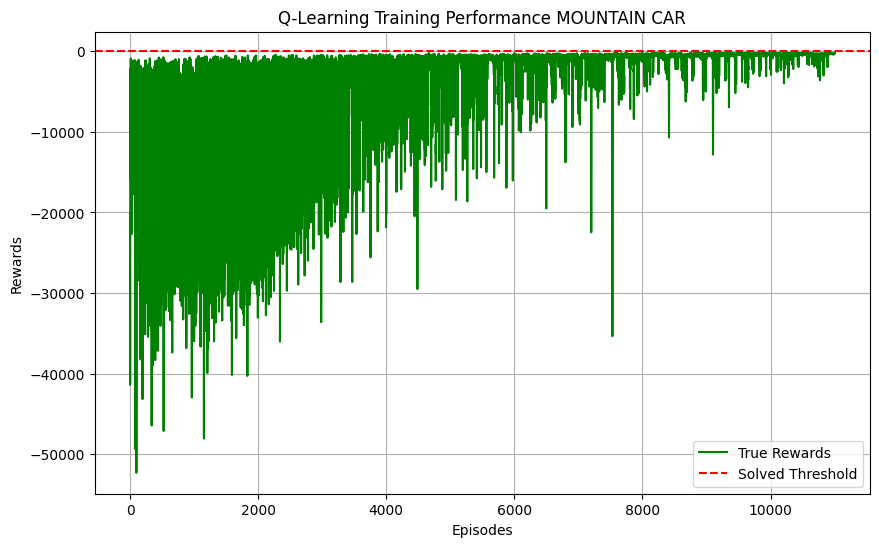

In [5]:
# Plot rewards and shaped rewards
solved_threshold = 0

plt.figure(figsize=(10, 6))
plt.plot(true_rewards_history, label='True Rewards', color='green')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('Q-Learning Training Performance MOUNTAIN CAR')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

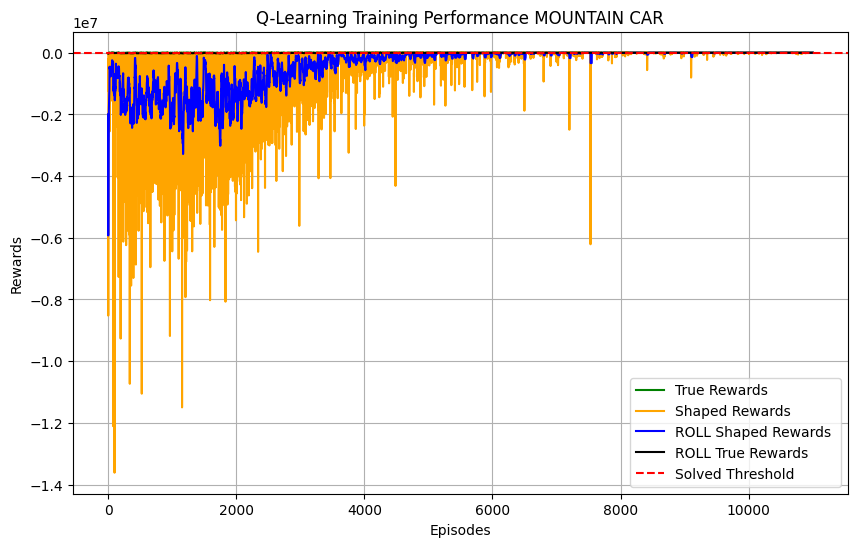

In [6]:
# Plot rewards and shaped rewards
solved_threshold = 0

plt.figure(figsize=(10, 6))
plt.plot(true_rewards_history, label='True Rewards', color='green')
plt.plot(shaped_rewards_history, label='Shaped Rewards ', color='orange')
plt.plot(rolling_avg_shaped, label='ROLL Shaped Rewards ', color='blue')
plt.plot(rolling_avg_True, label='ROLL True Rewards ', color='black')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('Q-Learning Training Performance MOUNTAIN CAR')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

In [7]:
# Test the learned policy
env = gym.make("MountainCar-v0", render_mode='human')
obs, _ = env.reset()
state = discretize(obs)
done = False
total_reward = 0

while not done:
    action = np.argmax(Q[state])
    obs, reward, terminated, truncated, _ = env.step(action)
    state = discretize(obs)
    done = terminated or truncated
    total_reward += reward
    env.render()

print(f"\nTotal reward: {total_reward}")


Total reward: -187.0
